# TabNet-Driven Predictive Modeling of Typhoid Fever Using Clinical Biomarkers in a Bangladeshi Cohort

## Introduction and Background

Typhoid fever is a significant public health challenge in Bangladesh. In this notebook, I utilized machine learning techniques to construct an accurate and interpretable diagnostic model for typhoid fever based on hematological, serological, and demographic biomarkers collected from a clinical dataset.

The model leverages **TabNet**, a deep learning architecture for tabular data, enhanced with a weighted loss function that addresses potential class imbalance. I also incorporated **Bayesian hyperparameter optimization** to efficiently tune the model parameters.

Instead of a single-run evaluation, the pipeline implements a robust model assessment using multiple random seeds, with average ROC curves and AUC ± standard deviation, which provides reliable estimates of generalization performance.

## Dataset Description

The dataset used in this study comprised clinical records collected from the Upazila Health Complex in Kalai, Jaipurhat, Bangladesh, encompassing 1,064 patients with clinically confirmed typhoid fever diagnoses, both positive and negative. The features included demographic variables such as age (ranging from 16 to over 77 years), sex, and blood group. The hematological biomarkers in the dataset comprised the erythrocyte sedimentation rate (ESR) and white blood cell (WBC) count, while the serological data consisted of Widal Test antibody titers targeting four antigens: TO, TH, AH, and BH. The dataset also records diagnostic outcomes, including blood culture results and the final clinical diagnosis (positive or negative for typhoid fever). The dataset is openly sourced from [[1]](https://data.mendeley.com/datasets/9hp4tgxz8f/1).

## Data Preprocessing and Feature Engineering

Data preprocessing involved several encoding and transformation steps to prepare the clinical dataset for the modeling. The `Gender` column was converted into a binary variable, with 0 representing males and 1 representing females. The erythrocyte sedimentation rate (ESR) feature was encoded as a binary indicator, assigned 1 if the status was "increase" and 0 otherwise. The blood culture results were similarly mapped to binary values, with positive cases coded as 1 and negative cases as 0. The Widal Test titers, originally embedded in complex text fields, were parsed using regular expressions to extract numerical antibody titers for each antigen, generating distinct features such as `TO_titer` and `TH_titer`. Blood group information was encoded using one-hot encoding into separate binary indicator columns, retaining only valid blood group types. The final clinical diagnosis was mapped to a binary target variable labeled `target`. Any remaining missing values after these preprocessing steps were excluded to ensure a clean dataset that was suitable for machine learning.

## Feature Importance Estimation

Prior to model development, feature importance was estimated using a TabNet classifier trained on the full feature set with the default hyperparameters. A stratified train-validation split was performed, and median imputation was exclusively applied to the training folds to prevent data leakage. To address the class imbalance inherent in the dataset, TabNet utilized a weighted binary cross-entropy loss function (`BCEWithLogitsLoss`) with the positive class weighted by the ratio of negative to positive samples (`pos_weight = num_neg / num_pos`). The resulting feature importance scores provided valuable insights into the relative contribution of each predictor, informing feature prioritization for subsequent modeling efforts and aiding the clinical interpretation of influential biomarkers.

## Variance Inflation Factor (VIF) Analysis

To evaluate potential multicollinearity among the predictor variables, I computed the Variance Inflation Factor (VIF) for a carefully selected subset of clinically relevant features. The features analyzed included `Age`, `Gender`, `WBC Count`, `TH_titer`, and `BloodGroup_B+`. This analysis aids in identifying redundant or highly correlated variables that could adversely affect model interpretability and stability, thereby guiding informed feature selection to enhance the robustness of downstream predictive modeling. 

## Modeling Approach: TabNet with Weighted Loss

The modeling approach employs a customized TabNet classifier, **TabNetClassifierWeighted**, which extends the standard TabNet architecture by incorporating a **pos_weight** parameter into the weighted binary cross-entropy loss function. This adjustment effectively addressed the class imbalance inherent in the typhoid fever dataset by increasing the sensitivity to the minority positive class without compromising the overall accuracy. TabNet’s sequential attention mechanism facilitates automatic feature selection and enhances model interpretability, making it particularly well-suited for complex tabular clinical data, where understanding feature contributions is critical.

## Bayesian optimization

Hyperparameter tuning was performed using **Bayesian Optimization** to efficiently explore the search space of the key model parameters. The optimized hyperparameters included the dimension sizes for the decision (`n_d`) and attention (`n_a`) steps, ranging from 8 to 24; the number of sequential attention steps (`n_steps`), between 3 and 10; the relaxation parameter controlling sparsity (`gamma`), from 1.0 to 2.0; the learning rate (`lr`), spanning 1e-4 to 1e-2; and the sparsity regularization coefficient (`lambda_sparse`), ranging from 0 to 1e-3. The objective function guiding the optimization was the average ROC-AUC calculated over a 3-fold stratified cross-validation to ensure a robust evaluation. The optimization process comprised three initial random explorations, followed by ten iterative refinements to effectively identify high-performing hyperparameters. The best parameters discovered through this process were subsequently used for the final model training in each experiment.

## Robust Model Evaluation Protocol


For each predefined feature set, the model training and evaluation were repeated across five distinct random seeds (`[42, 999, 1, 9999, 10]`) to ensure robustness and to assess variability. Within each iteration, the dataset was split into stratified training and testing subsets using an 80%-20% ratio to preserve the class distribution. Median imputation was performed exclusively on the training data, and the resulting imputer was applied to the test set to prevent data leakage. Bayesian hyperparameter optimization was conducted solely on the training data to identify the best model parameters, after which a TabNet model was trained using these optimal settings. The predictive performance of the model was then evaluated on the held-out test set by computing the ROC curve and corresponding area under the curve (AUC). To aggregate the results, the ROC curves from all five seeds were interpolated onto a common false-positive rate (FPR) axis and averaged pointwise, producing a robust ensemble ROC curve. The performance was summarized using the mean AUC along with its standard deviation, providing an informative measure of stability and reliability for each feature subset under varied data splits.

## Code Proper

In [2]:
!pip install pytorch-tabnet bayesian-optimization scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pytorch-tabnet]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from bayes_opt import BayesianOptimization
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# --- Preprocessing functions and classes ---

def extract_titer(titer_str, antigen):
    match = re.search(rf'{antigen}\s*=\s*1:(\d+)', titer_str)
    return int(match.group(1)) if match else np.nan

def preprocess_data(df_raw):
    df = df_raw.copy()
    df.columns = df.columns.str.strip()

    if 'Gender' in df.columns and df['Gender'].dtype == object:
        df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

    if 'ESR' in df.columns and df['ESR'].dtype == object:
        df['ESR'] = df['ESR'].apply(lambda x: 1 if str(x).lower() == 'increase' else 0)

    if 'Blood Culture' in df.columns and df['Blood Culture'].dtype == object:
        df['Blood Culture'] = df['Blood Culture'].map({
            'Positive': 1, 'Negative': 0,
            'positive': 1, 'negative': 0
        })

    if 'Widal Test' in df.columns:
        df['TO_titer'] = df['Widal Test'].apply(lambda x: extract_titer(str(x), 'TO'))
        df['TH_titer'] = df['Widal Test'].apply(lambda x: extract_titer(str(x), 'TH'))
        df['AH_titer'] = df['Widal Test'].apply(lambda x: extract_titer(str(x), 'AH'))
        df['BH_titer'] = df['Widal Test'].apply(lambda x: extract_titer(str(x), 'BH'))
        df.drop(columns=['Widal Test'], inplace=True)

    if 'Blood Group' in df.columns:
        df['Blood Group'] = df['Blood Group'].astype(str).str.strip().str.upper()
        mask_valid_bg = df['Blood Group'].str.match(r'.*[+-]$')
        df = df[mask_valid_bg].copy()
        cols_to_drop = [col for col in df.columns if col.startswith('BloodGroup_')]
        if cols_to_drop:
            df.drop(columns=cols_to_drop, inplace=True)
        blood_group_dummies = pd.get_dummies(df['Blood Group'], prefix='BloodGroup').astype(int)
        df = pd.concat([df, blood_group_dummies], axis=1)
        df.drop(columns=['Blood Group'], inplace=True)

    if 'Final Output' in df.columns:
        df['target'] = df['Final Output'].map({'Positive': 1, 'Negative': 0})
        df.drop(columns=['Final Output'], inplace=True)
    elif 'target' not in df.columns:
        raise ValueError("Dataframe must have either 'target' or 'Final Output' column")

    df.columns = df.columns.str.strip()
    df = df.dropna()  # Drop any remaining NA
    return df

class TabNetClassifierWeighted(TabNetClassifier):
    def fit(self, X_train, y_train,
            eval_set=None,
            eval_name=None,
            eval_metric=None,
            max_epochs=30,
            patience=20,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            pos_weight=None,
            **kwargs):
        if pos_weight is not None:
            pw = torch.tensor([pos_weight], dtype=torch.float)
            if torch.cuda.is_available():
                pw = pw.cuda()
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
        return super().fit(
            X_train, y_train,
            eval_set=eval_set,
            eval_name=eval_name,
            eval_metric=eval_metric,
            max_epochs=max_epochs,
            patience=patience,
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            num_workers=num_workers,
            drop_last=drop_last,
            **kwargs
        )

def calculate_vif(df, features):
    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

def compute_feature_importance(df, random_state=42):
    feature_cols = df.columns.drop('target')
    X = df[feature_cols].values
    y = df['target'].values

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state)

    imputer = SimpleImputer(strategy='median')
    X_train = imputer.fit_transform(X_train).astype(np.float32)
    X_val = imputer.transform(X_val).astype(np.float32)

    num_pos = np.sum(y_train == 1)
    num_neg = np.sum(y_train == 0)
    pos_weight = num_neg / max(num_pos, 1)

    default_params = {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 5,
        'gamma': 1.4,
        'lambda_sparse': 0.005,
        'lr': 0.005
    }

    model = TabNetClassifierWeighted(
        n_d=default_params['n_d'],
        n_a=default_params['n_a'],
        n_steps=default_params['n_steps'],
        gamma=default_params['gamma'],
        lambda_sparse=default_params['lambda_sparse'],
        optimizer_params=dict(lr=default_params['lr']),
        mask_type='sparsemax',
        seed=random_state,
        verbose=0
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=50,
        patience=7,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        pos_weight=pos_weight
    )

    feature_importances = model.feature_importances_

    fi_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return fi_df, model

def plot_feature_importance(fi_df, top_n=20):
    top_df = fi_df.head(top_n)
    plt.figure(figsize=(12, 7))
    plt.barh(top_df['feature'][::-1], top_df['importance'][::-1], color='dodgerblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top Feature Importances from TabNet')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

def hyperparameter_cv(X, y, pos_weight, n_splits=3, random_state=42):
    def objective_function(n_d, n_a, n_steps, gamma, lr, lambda_sparse):
        n_d = int(round(n_d))
        n_a = int(round(n_a))
        n_steps = int(round(n_steps))

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        aucs = []

        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            imputer_cv = SimpleImputer(strategy='median')
            X_train_fold = imputer_cv.fit_transform(X_train_fold).astype(np.float32)
            X_val_fold = imputer_cv.transform(X_val_fold).astype(np.float32)

            clf = TabNetClassifierWeighted(
                n_d=n_d,
                n_a=n_a,
                n_steps=n_steps,
                gamma=gamma,
                lambda_sparse=lambda_sparse,
                optimizer_params=dict(lr=lr),
                mask_type='sparsemax',
                seed=random_state,
                verbose=0
            )
            clf.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric=['auc'],
                max_epochs=30,
                patience=10,
                batch_size=256,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False,
                pos_weight=pos_weight
            )

            preds = clf.predict_proba(X_val_fold)[:, 1]
            auc_val = roc_auc_score(y_val_fold, preds)
            aucs.append(auc_val)

        mean_auc = np.mean(aucs)
        print(f"Tuning params: n_d={n_d}, n_a={n_a}, n_steps={n_steps}, gamma={gamma:.3f}, lr={lr:.5f}, lambda_sparse={lambda_sparse:.6f} => Mean AUC: {mean_auc:.4f}")
        return mean_auc

    pbounds = {
        'n_d': (8, 24),
        'n_a': (8, 24),
        'n_steps': (3, 10),
        'gamma': (1.0, 2.0),
        'lr': (1e-4, 1e-2),
        'lambda_sparse': (0, 1e-3)
    }

    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=pbounds,
        random_state=random_state,
        verbose=2
    )

    optimizer.maximize(init_points=3, n_iter=10)
    best_params = optimizer.max['params']
    best_params['n_d'] = int(round(best_params['n_d']))
    best_params['n_a'] = int(round(best_params['n_a']))
    best_params['n_steps'] = int(round(best_params['n_steps']))

    return best_params

def train_evaluate_model(df, selected_features, random_state=42, test_size=0.2, max_epochs=50):
    df_model = df.dropna(subset=selected_features + ['target'])
    X = df_model[selected_features].values
    y = df_model['target'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    num_pos = np.sum(y_train == 1)
    num_neg = np.sum(y_train == 0)
    pos_weight = num_neg / max(num_pos, 1)

    best_params = hyperparameter_cv(X_train, y_train, pos_weight, n_splits=3, random_state=random_state)
    print(f"\nSeed {random_state} - Best hyperparameters found: {best_params}")

    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train).astype(np.float32)
    X_test_imp = imputer.transform(X_test).astype(np.float32)

    model = TabNetClassifierWeighted(
        n_d=best_params['n_d'],
        n_a=best_params['n_a'],
        n_steps=best_params['n_steps'],
        gamma=best_params['gamma'],
        lambda_sparse=best_params['lambda_sparse'],
        optimizer_params=dict(lr=best_params['lr']),
        mask_type='sparsemax',
        seed=random_state,
        verbose=0)

    model.fit(
        X_train_imp, y_train,
        eval_set=[(X_test_imp, y_test)],
        eval_name=['test'],
        eval_metric=['auc'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        pos_weight=pos_weight)

    y_pred_prob = model.predict_proba(X_test_imp)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    return fpr, tpr, auc

def evaluate_model_multiple_seeds(df, features, seeds, test_size=0.2, max_epochs=50):
    common_fpr = np.linspace(0, 1, 100)
    tpr_collection = []
    aucs = []

    for seed in seeds:
        fpr, tpr, auc = train_evaluate_model(df, features, random_state=seed,
                                            test_size=test_size, max_epochs=max_epochs)
        aucs.append(auc)
        tpr_interp = np.interp(common_fpr, fpr, tpr)
        tpr_collection.append(tpr_interp)

    mean_tpr = np.mean(tpr_collection, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    return common_fpr, mean_tpr, mean_auc, std_auc

def plot_avg_roc_curve(fpr, tpr, mean_auc, std_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr,
             color='darkorange', lw=2,
             label=f'Mean ROC curve (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Average ROC Curve over multiple seeds')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def print_results(mean_auc, std_auc, features):
    print(f"Features: {features}")
    print(f"Average AUC: {mean_auc:.4f} ± {std_auc:.4f}\n")

def main0():
    df_raw = pd.read_csv('Typhoid_bangladesh.csv')
    df = preprocess_data(df_raw)


    # Feature importance once on entire feature set
    print("\nComputing Feature Importance on entire feature set...")
    fi_df, fi_model = compute_feature_importance(df)
    print(fi_df.head(20))
    plot_feature_importance(fi_df)
    
    # VIF computed once on reduced cols
    cols_reduced = ['Age', 'Gender', 'WBC Count', 'TH_titer', 'BloodGroup_B+']
    print("Variance Inflation Factor (VIF) on cols_reduced:")
    vif_df = calculate_vif(df, cols_reduced)
    print(vif_df)


def main():
    df_raw = pd.read_csv('Typhoid_bangladesh.csv')
    df = preprocess_data(df_raw)
    seeds = [42, 999, 1, 9999, 10]

    feature_sets = [
        ['TH_titer'],
        ['TH_titer', 'WBC Count'],
        ['TH_titer', 'WBC Count', 'Age'],
        ['TH_titer', 'WBC Count', 'Age', 'BloodGroup_B+'],
        ['TH_titer', 'WBC Count', 'Age', 'BloodGroup_B+', 'Gender']
    ]

    for i, features in enumerate(feature_sets, 1):
        print(f"\n--- Model {i}: Using features = {features} ---")
        fpr, tpr, mean_auc, std_auc = evaluate_model_multiple_seeds(df, features, seeds)
        print_results(mean_auc, std_auc, features)
        plot_avg_roc_curve(fpr, tpr, mean_auc, std_auc)


Computing Feature Importance on entire feature set...

Early stopping occurred at epoch 14 with best_epoch = 7 and best_val_auc = 0.93064
           feature  importance
8         BH_titer    0.790193
6         TH_titer    0.057556
5         TO_titer    0.031662
7         AH_titer    0.029080
4    Blood Culture    0.021231
15   BloodGroup_O-    0.016878
10   BloodGroup_A-    0.008872
0              Age    0.007870
1           Gender    0.007169
2              ESR    0.006387
13   BloodGroup_B-    0.005211
9    BloodGroup_A+    0.004821
14   BloodGroup_O+    0.004419
12   BloodGroup_B+    0.004044
11  BloodGroup_AB+    0.002989
3        WBC Count    0.001618


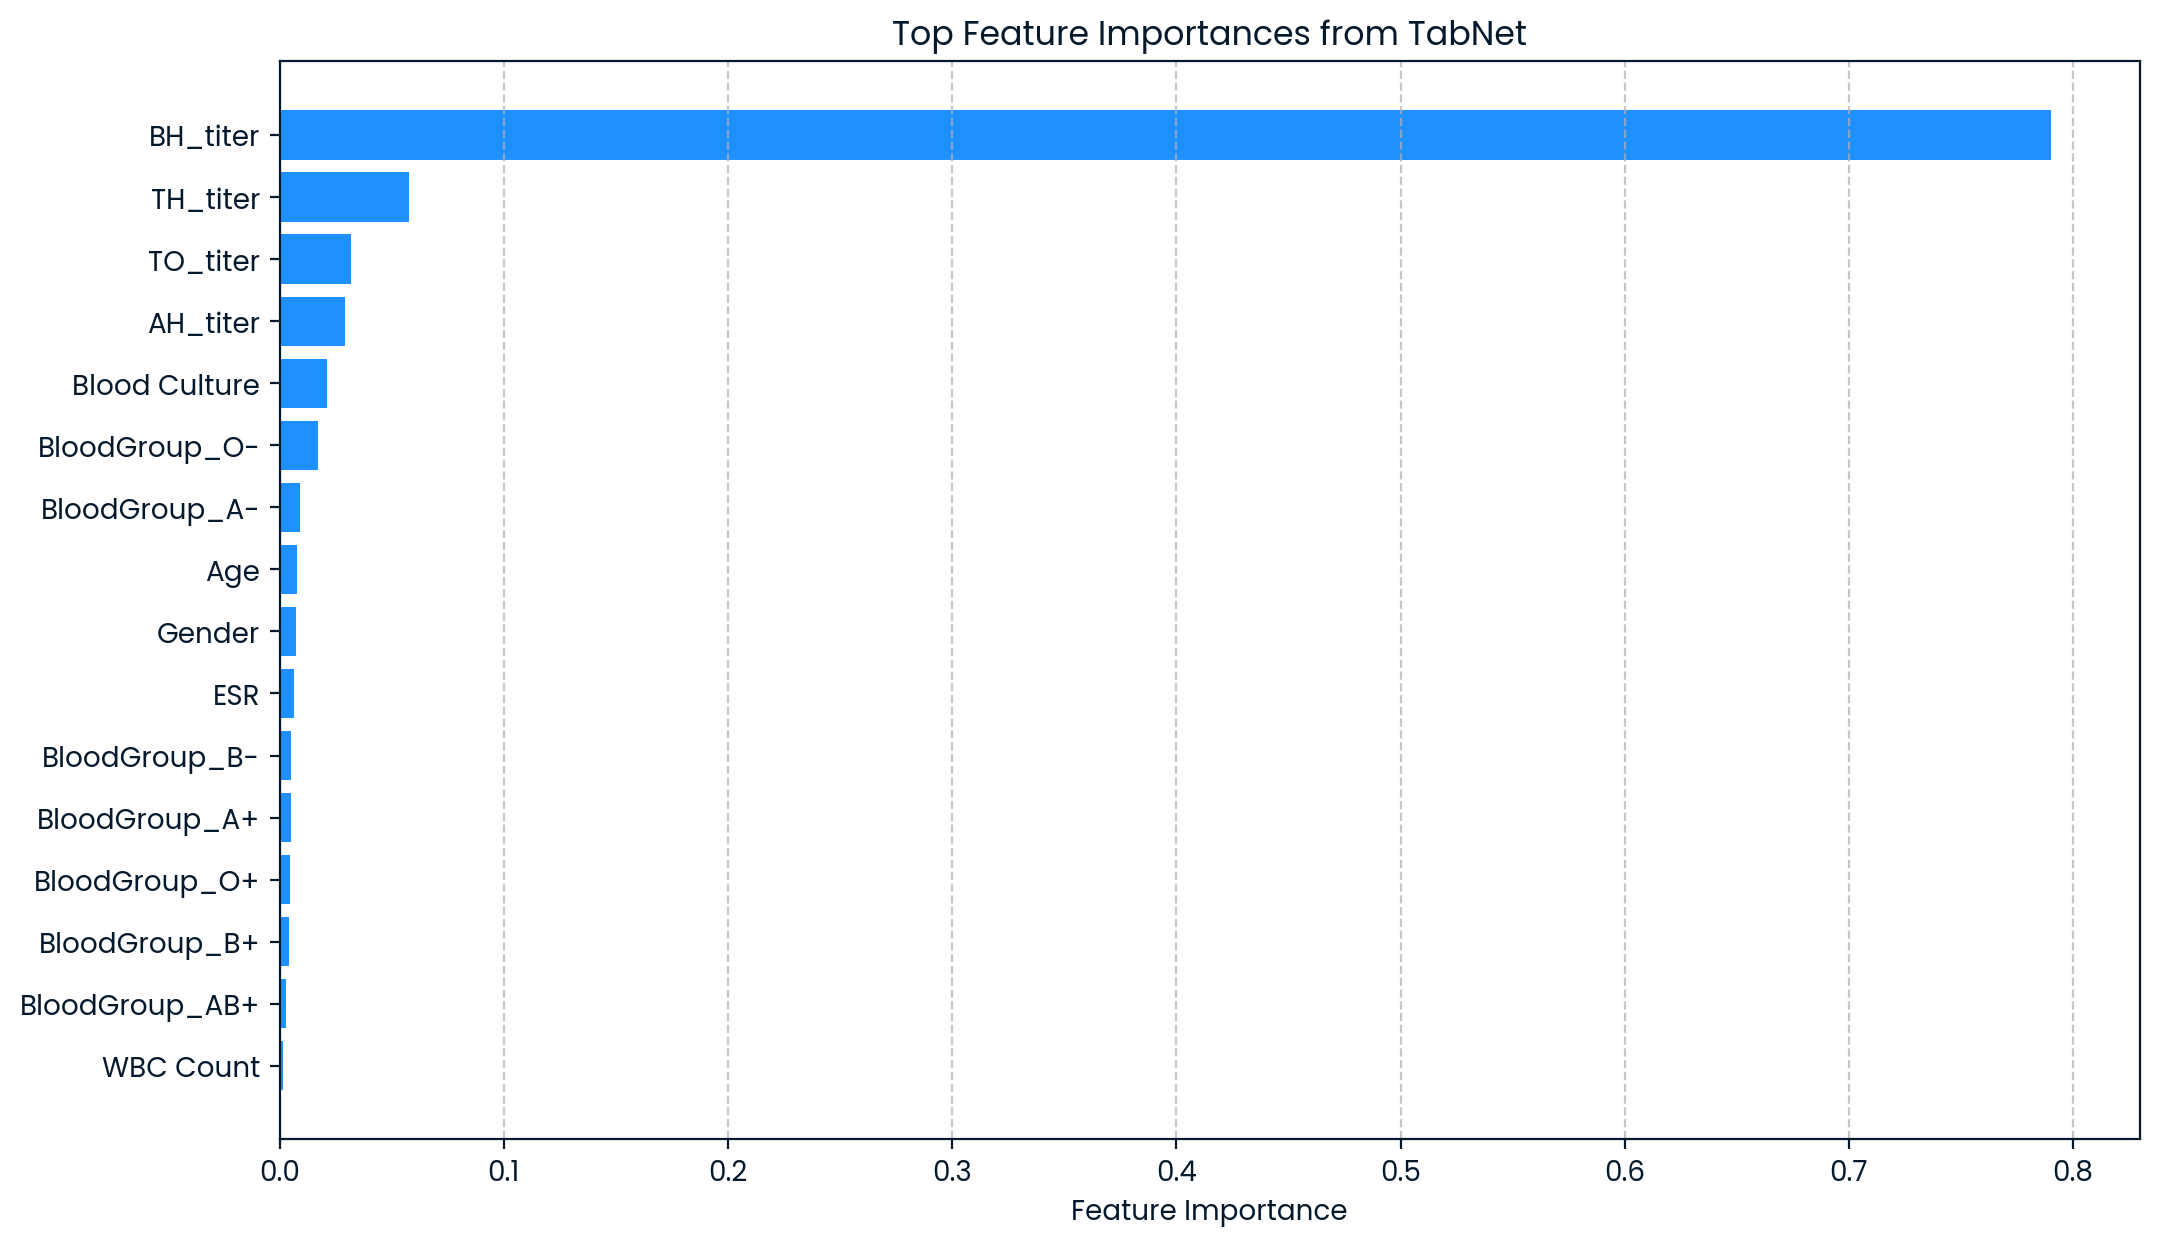

Variance Inflation Factor (VIF) on cols_reduced:
         feature       VIF
3       TH_titer  2.967910
2      WBC Count  2.961933
0            Age  1.003542
4  BloodGroup_B+  1.003018
1         Gender  1.001968


In [7]:
# feature importance and VIF
if __name__ == "__main__":
    main0()


--- Model 1: Using features = ['TH_titer'] ---
|   iter    |  target   |    n_d    |    n_a    |  n_steps  |   gamma   |    lr     | lambda... |
-------------------------------------------------------------------------------------------------

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_auc = 1.0

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_auc = 1.0

Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_auc = 1.0
Tuning params: n_d=14, n_a=23, n_steps=8, gamma=1.599, lr=0.00164, lambda_sparse=0.000156 => Mean AUC: 1.0000
| 1         | 1.0       | 13.992641 | 23.211428 | 8.1239575 | 1.5986584 | 0.0016445 | 0.0001559 |

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.0

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.0

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.0
Tuning params: n_d=9, n_a=22, n_steps=7, gamma=1.708, lr

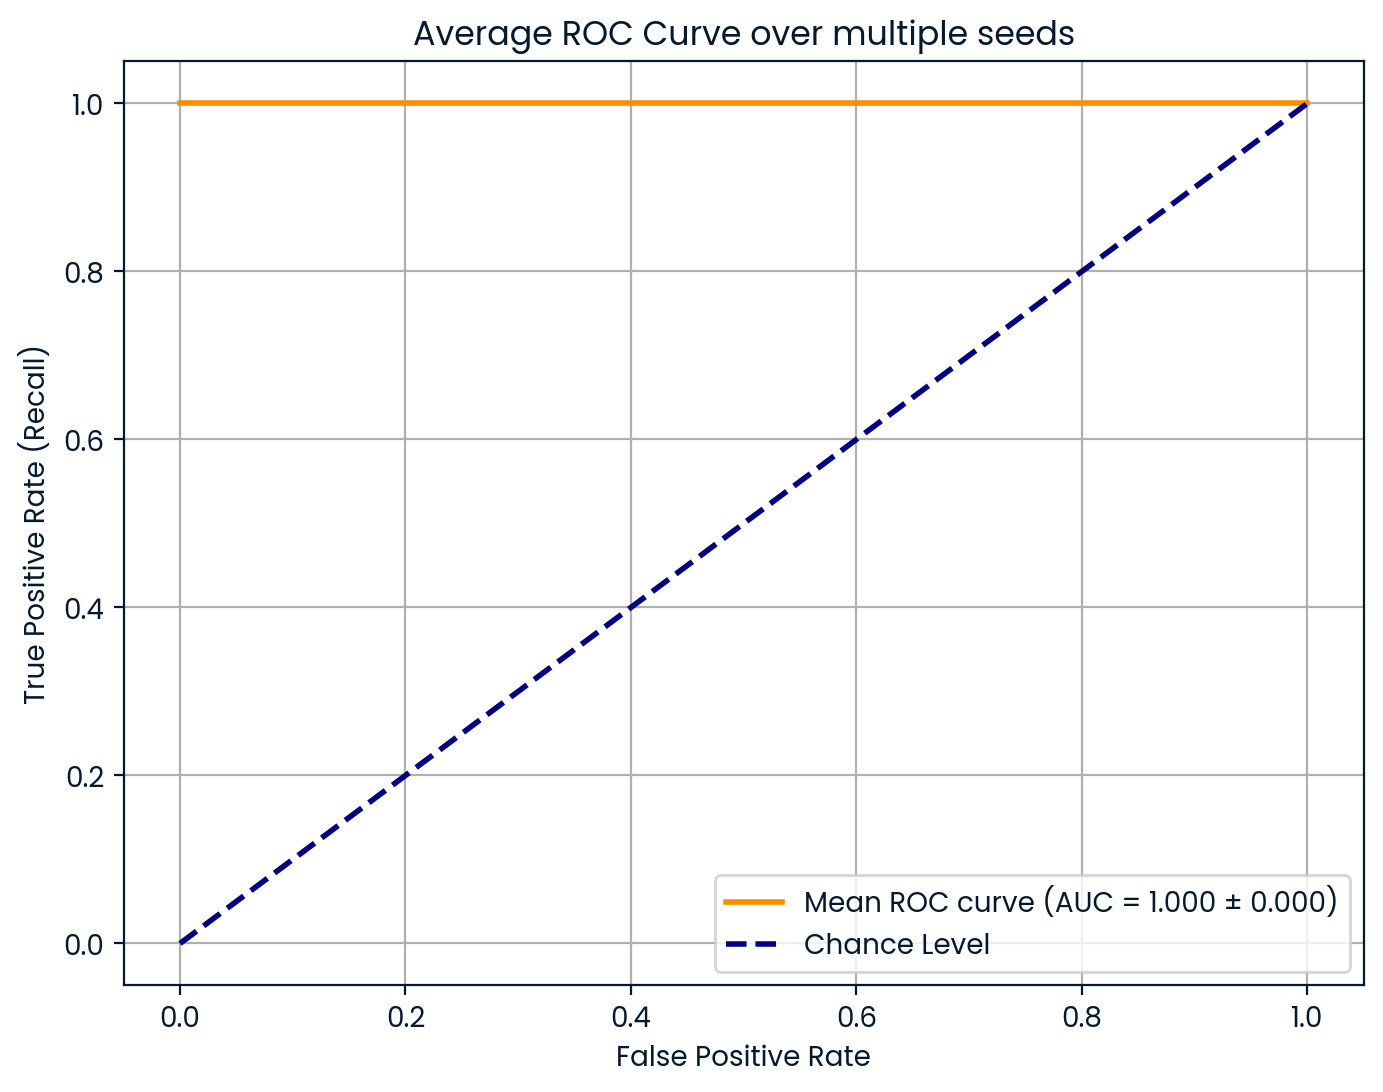


--- Model 2: Using features = ['TH_titer', 'WBC Count'] ---
|   iter    |  target   |    n_d    |    n_a    |  n_steps  |   gamma   |    lr     | lambda... |
-------------------------------------------------------------------------------------------------
Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_0_auc = 0.9999
Stop training because you reached max_epochs = 30 with best_epoch = 20 and best_val_0_auc = 1.0

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_auc = 1.0
Tuning params: n_d=14, n_a=23, n_steps=8, gamma=1.599, lr=0.00164, lambda_sparse=0.000156 => Mean AUC: 1.0000
| 1         | 0.9999651 | 13.992641 | 23.211428 | 8.1239575 | 1.5986584 | 0.0016445 | 0.0001559 |

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_auc = 0.96385

Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_auc = 1.0

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_auc = 0.95954
Tuni

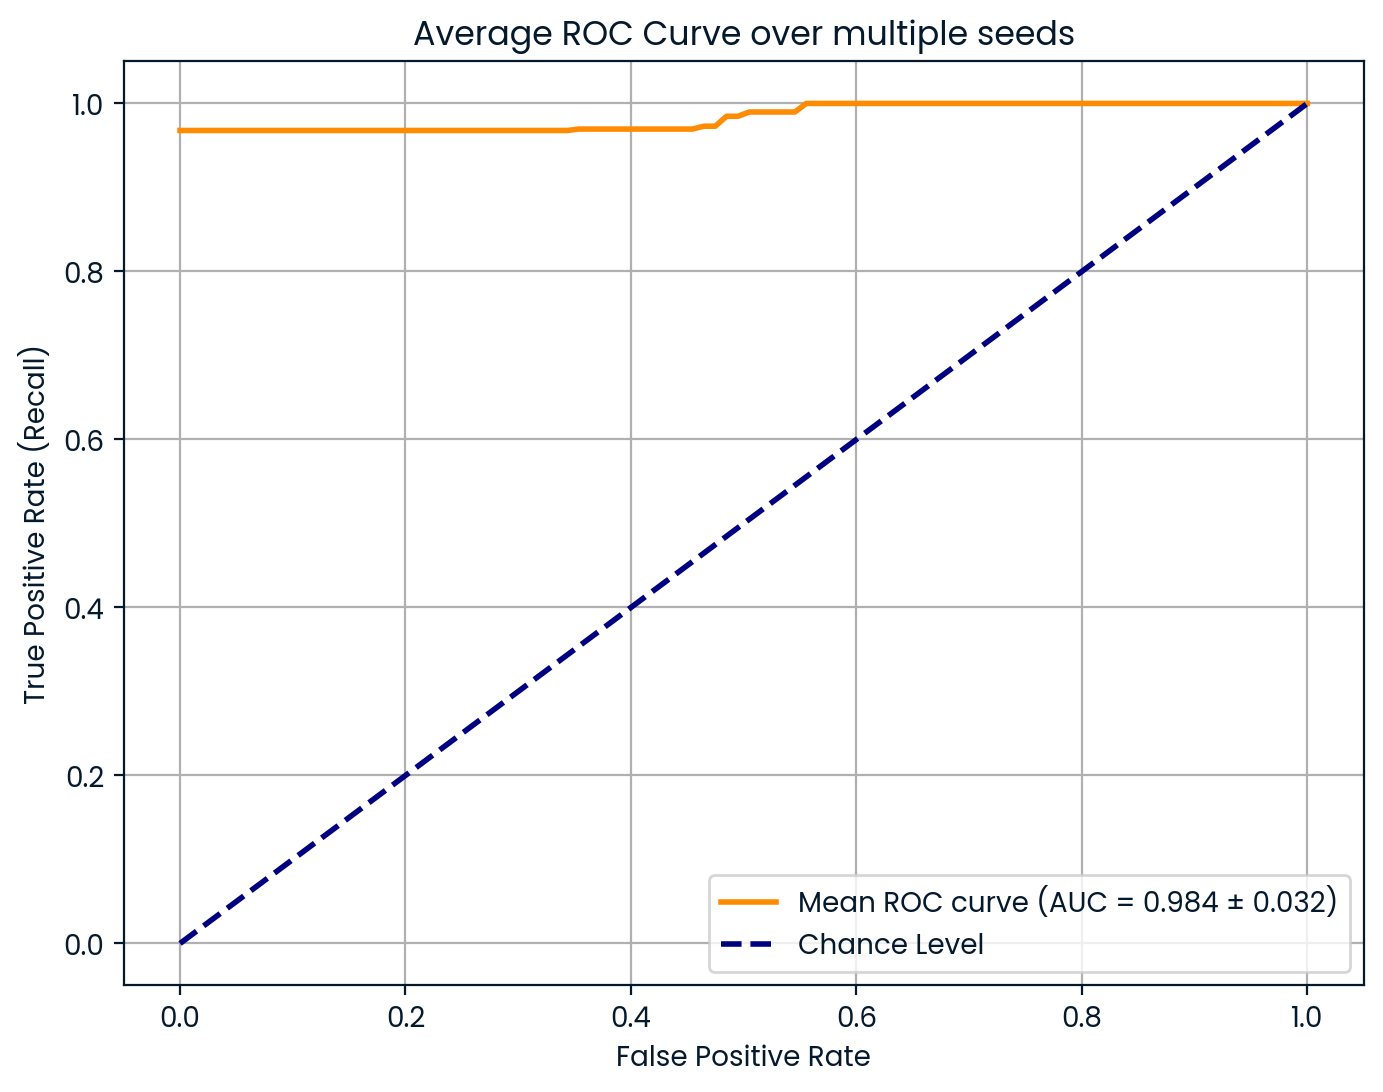


--- Model 3: Using features = ['TH_titer', 'WBC Count', 'Age'] ---
|   iter    |  target   |    n_d    |    n_a    |  n_steps  |   gamma   |    lr     | lambda... |
-------------------------------------------------------------------------------------------------

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_auc = 1.0

Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_auc = 0.98982
Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_val_0_auc = 1.0
Tuning params: n_d=14, n_a=23, n_steps=8, gamma=1.599, lr=0.00164, lambda_sparse=0.000156 => Mean AUC: 0.9966
| 1         | 0.9966064 | 13.992641 | 23.211428 | 8.1239575 | 1.5986584 | 0.0016445 | 0.0001559 |
Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_0_auc = 0.97625
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.99979
Stop training because you reached max_epochs = 30 with best_ep

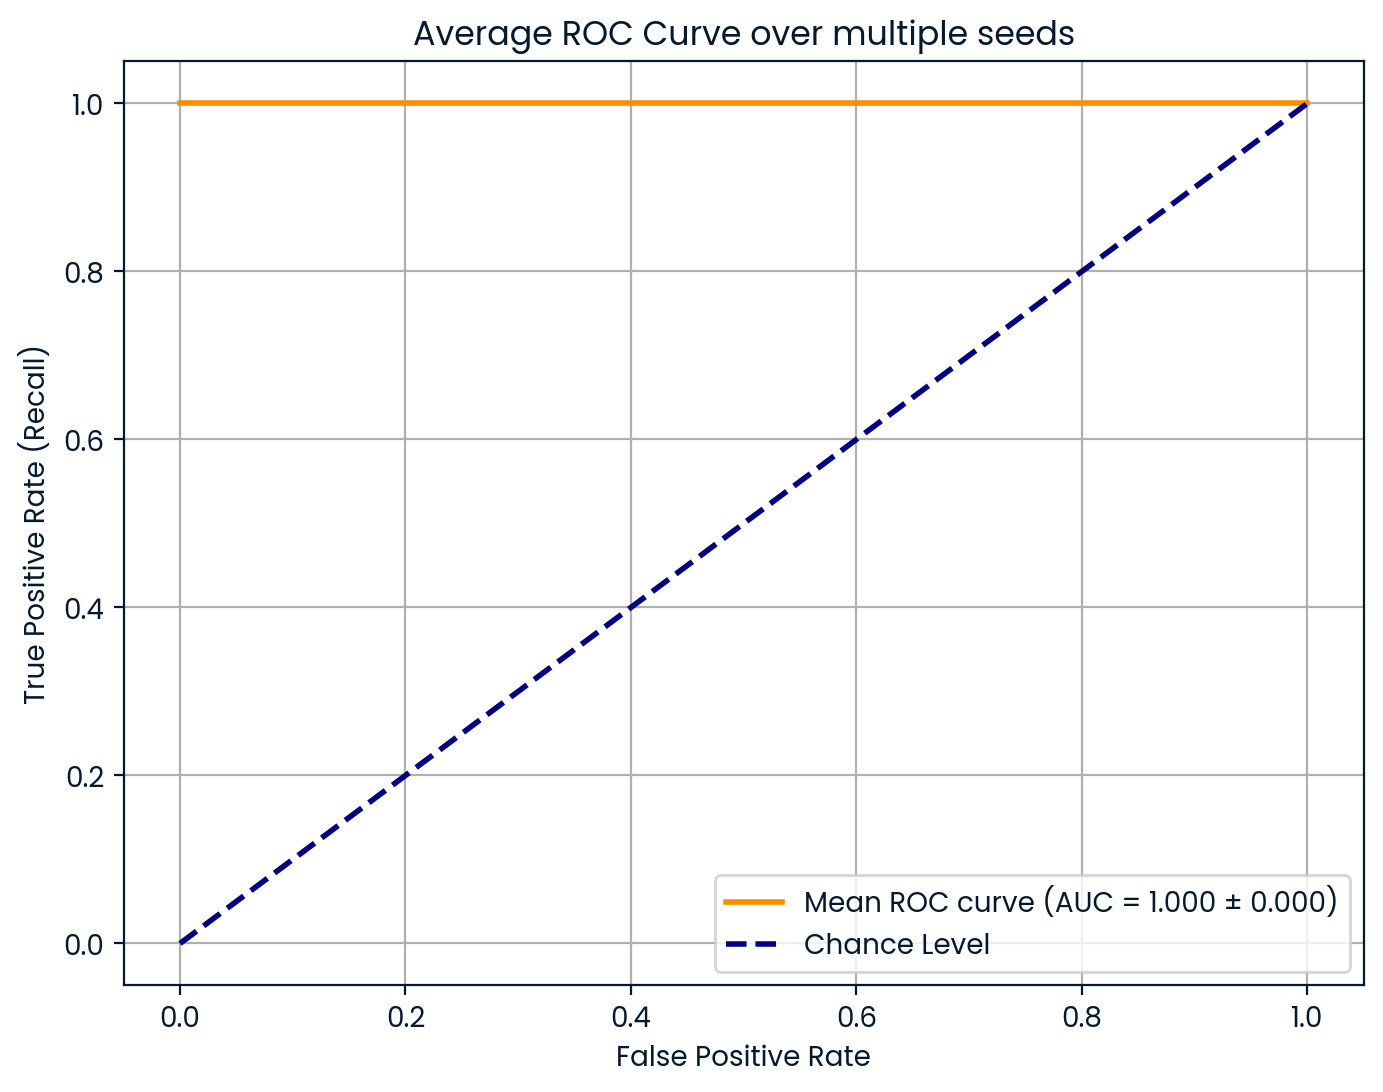


--- Model 4: Using features = ['TH_titer', 'WBC Count', 'Age', 'BloodGroup_B+'] ---
|   iter    |  target   |    n_d    |    n_a    |  n_steps  |   gamma   |    lr     | lambda... |
-------------------------------------------------------------------------------------------------
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.99901

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 1.0

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_auc = 0.9679
Tuning params: n_d=14, n_a=23, n_steps=8, gamma=1.599, lr=0.00164, lambda_sparse=0.000156 => Mean AUC: 0.9890
| 1         | 0.9889680 | 13.992641 | 23.211428 | 8.1239575 | 1.5986584 | 0.0016445 | 0.0001559 |

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.8109

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.74713

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_

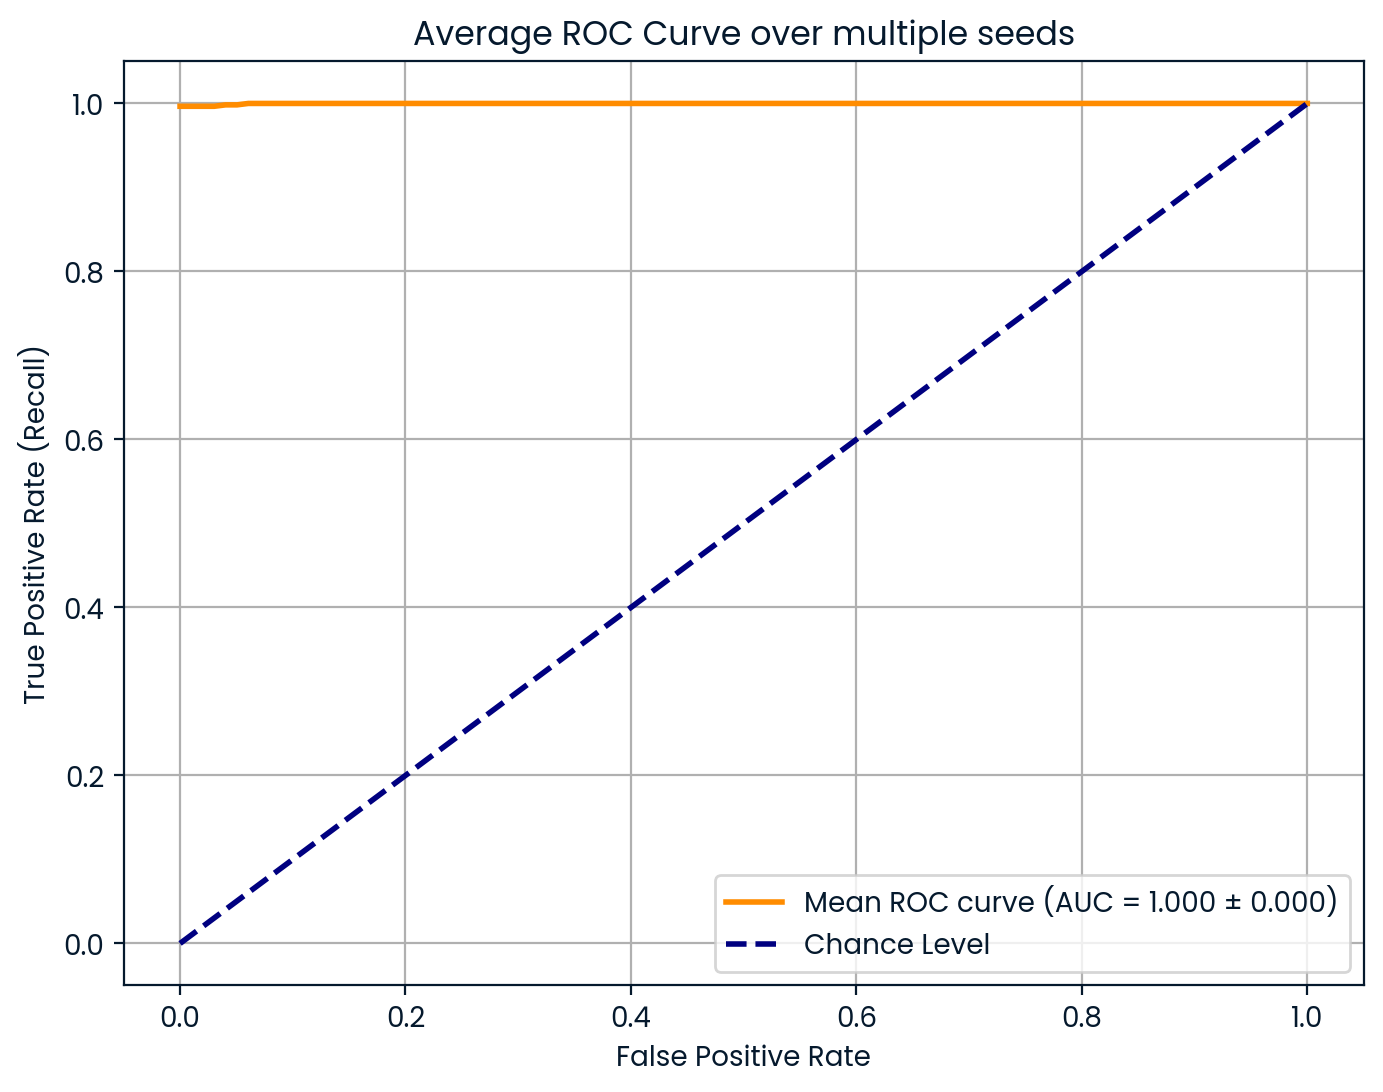


--- Model 5: Using features = ['TH_titer', 'WBC Count', 'Age', 'BloodGroup_B+', 'Gender'] ---
|   iter    |  target   |    n_d    |    n_a    |  n_steps  |   gamma   |    lr     | lambda... |
-------------------------------------------------------------------------------------------------
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.9964
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.9988
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_0_auc = 0.99937
Tuning params: n_d=14, n_a=23, n_steps=8, gamma=1.599, lr=0.00164, lambda_sparse=0.000156 => Mean AUC: 0.9982
| 1         | 0.9981887 | 13.992641 | 23.211428 | 8.1239575 | 1.5986584 | 0.0016445 | 0.0001559 |

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.72959

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.65958
Stop training because you reach

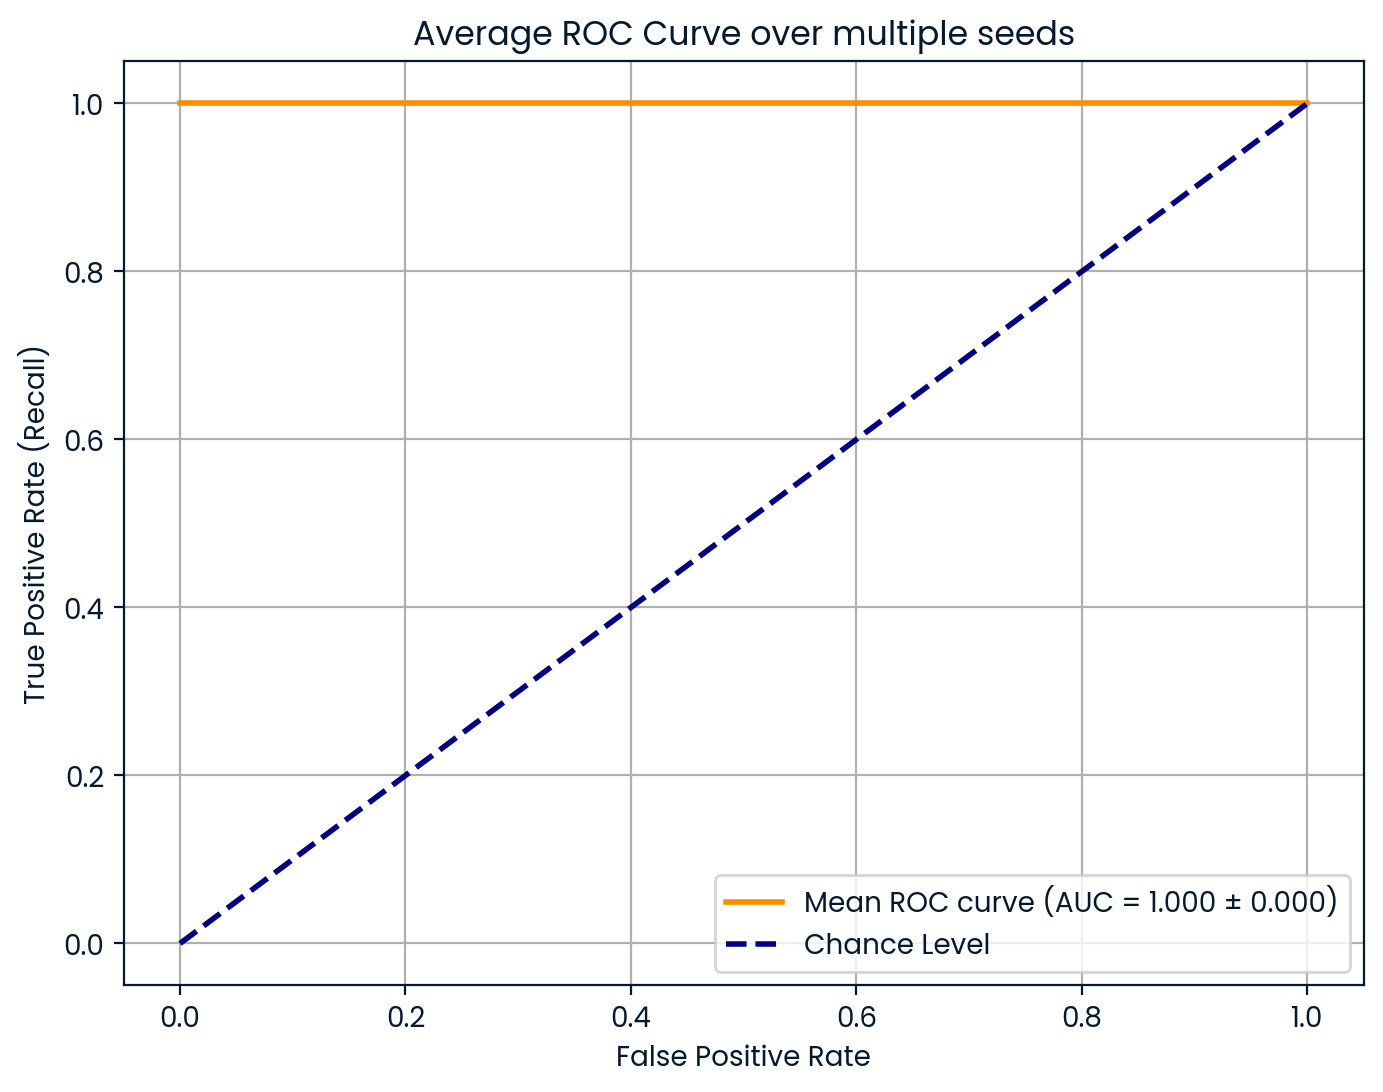

In [2]:
if __name__ == "__main__":
    main()

<Axes: xlabel='target', ylabel='TH_titer'>

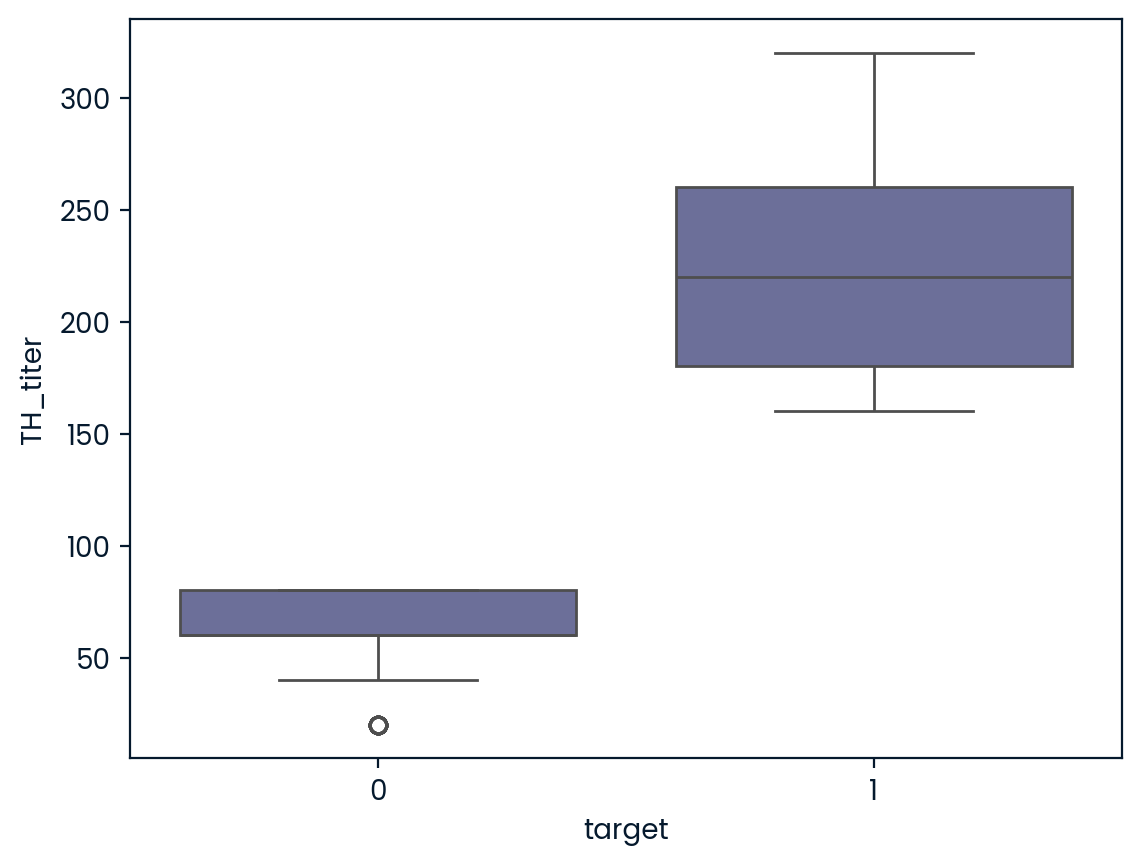

In [10]:
import seaborn as sns
df_raw = pd.read_csv('Typhoid_bangladesh.csv')
df = preprocess_data(df_raw)
sns.boxplot(x=df['target'], y=df['TH_titer'])

## Results


I conducted a feature importance analysis to identify the most influential predictors among the full set of clinical and demographic variables for the diagnosis of typhoid fever. A TabNet model was trained on the entire preprocessed dataset (without Bayesian hyperparameter optimization) to extract the baseline feature importance scores. The results revealed that **BH_titer**, a serological antibody titer, overwhelmingly dominated the predictive landscape, accounting for nearly 79% of the total feature importance. Other antibody titers, including `TH_titer`, `TO_titer`, and `AH_titer`, contributed smaller proportions, followed by clinical indicators such as `Blood Culture.’ Demographic (` age ` ` and sex) and hematological (`WBC Count`, `ESR`) features demonstrated marginal importance in comparison, while among blood group indicators, `BloodGroup_O-` and `BloodGroup_A-` showed moderate importance, with `BloodGroup_B+` also presenting a noticeable influence.

However, due to an exceptionally high Variance Inflation Factor (VIF) associated with the `BH_titer` feature, indicating strong multicollinearity that could jeopardize model stability, `TH_titer` was chosen for further variance inflation assessment and modeling. VIF analysis was conducted on a reduced subset of features, including ` age `, sex, `WBC count `, `TH_titer`, and `BloodGroup_B+`. Among all the titer variables, `TH_titer` demonstrated the lowest VIF, supporting its selection as the representative serological feature. The VIF values for this curated subset were all well below the critical thresholds, with `TH_titer` and `WBC Count` near 3.0, and demographic and blood group features close to 1.0, indicating minimal multicollinearity and endorsing their stable inclusion in predictive modeling.

Using this refined feature set, five predictive models were trained and evaluated using Bayesian-optimized TabNet classifiers across multiple random seeds for robustness. The model using only `TH_titer` achieved perfect classification performance, with an average ROC-AUC of 1.000 ± 0.000. The addition of `WBC Count` resulted in a slight increase in variance but maintained an excellent AUC of 0.984 ± 0.032. The inclusion of ` age ` restored a perfect average AUC (1.000 ± 0.000), reflecting the demographic variable’s complementary value. Adding `BloodGroup_B+` and `Gender` did not diminish performance, with these multi-feature models perfectly matching the AUC of the single-feature model. Early stopping and hyperparameter tuning ensured well-regularized and stable models throughout the study.



### Discussion

The feature importance analysis highlighted the dominant role of serological antibody titers in typhoid fever diagnosis, with `BH_titer` showing an overwhelming contribution. Nevertheless, the high multicollinearity of `BH_titer` rendered it unsuitable for inclusion in parsimonious, stable predictive models, as evidenced by its inflated VIF. Selecting `TH_titer`, the titer with the lowest VIF among serological markers, balances relevance and statistical reliability. This prevents variance inflation that could undermine the model estimation.

The VIF results confirmed the appropriateness of this refined feature subset, with all variables exhibiting acceptable collinearity levels. The focused inclusion of `BloodGroup_B+` while excluding redundant blood group categories effectively avoids the multicollinearity issues inherent to one-hot encoding, supporting the model interpretability and stability.

Model evaluation showed that the single `TH_titer` feature alone was sufficient to achieve near-perfect diagnostic accuracy, with incremental feature additions providing negligible gains. As demonstrated in the accompanying boxplot (see image above), TH_titer values exhibited a clear and consistent separation between positive and negative typhoid cases, underscoring its strong discriminatory power. This parsimonious model achieved an average AUC of 1.000 without the complexity and potential overfitting risks associated with additional features. By relying solely on TH_titer, the model maintains maximal accuracy while enhancing interpretability and feasibility for practical deployment in clinical settings. The `TH_titer`-based TabNet model supports a parsimonious modeling approach, which is advantageous for clinical application by reducing complexity, cost, and overfitting risks, which is particularly important in low-resource environments such as Bangladesh. 

I will explore other ML models like XGBoost, classic MLP, and random forest models for future work and compare performance results with those from the TabNet model.

In summary, integrating rigorous feature importance ranking with multicollinearity assessment via the VIF enables the development of robust, interpretable, and efficient diagnostic models. This pipeline justifies prioritizing `TH_titer` as the central biomarker for typhoid fever prediction, setting a strong foundation for practical and resource-conscious clinical implementation.

If you have questions, kindly send them in at jprmaulion[at]gmail[dot]com. Cheers and happy holidays!
